EN2550 Excercise 08

Index No.&nbsp;&nbsp;:&nbsp;190018V

Name&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:&nbsp;Abeywickrama K.C.S.

Github &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;:&nbsp;https://github.com/KCSAbeywickrama/EN2550-Excercises

In [29]:
# imports
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def imshowBGR(img,ax=plt):
    plt.figure()
    ax.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))

P1 =  [[ 4.80251845e+01  1.44011271e+03 -5.71648932e+02  7.53293366e+01]
 [ 1.53577034e+03 -6.41434324e+01 -1.63127843e+02  1.85810055e+02]
 [ 4.88387837e-02 -1.81568392e-01 -9.82164799e-01  6.14604846e-01]]
P2 =  [[-1.55882371e+02  1.44377186e+03 -5.42436214e+02  6.81806220e+01]
 [ 1.34928131e+03 -8.41979541e+01 -7.49443961e+02  1.99929996e+02]
 [-3.40999743e-01 -1.74474039e-01 -9.23730472e-01  6.00850565e-01]]


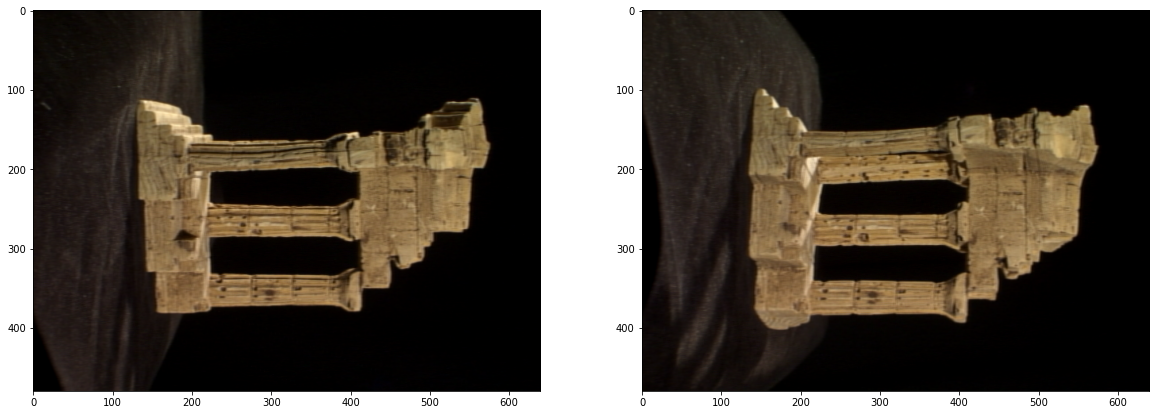

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [30]:
# q1, q2

f=open(r'templeSparseRing\templeSR_par.txt','r')
assert f is not None

# 1st image
n=int(f.readline())
l=f.readline().split()
im1_fn=l[0]


K1=np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1=np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1=np.array([float(i) for i in l[19:22]]).reshape((3,1))

# 2nd image

l=f.readline().split()
im2_fn=l[0]

K2=np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2=np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2=np.array([float(i) for i in l[19:22]]).reshape((3,1))

# read the 2 images & show
im1=cv.imread(r'templeSparseRing/'+im1_fn,cv.IMREAD_COLOR)
im2=cv.imread(r'templeSparseRing/'+im2_fn,cv.IMREAD_COLOR)

fix,ax=plt.subplots(1,2,figsize=(20,20))
imshowBGR(im1,ax[0])
imshowBGR(im2,ax[1])

P1=K1 @ np.hstack((R1,t1))
P2=K2 @ np.hstack((R2,t2))

print("P1 = ", P1)
print("P2 = ", P2)


In [31]:
# q3

from scipy.linalg import null_space                                       
def skew(x):                                                              
    x = x.ravel()                                                             
    return np. array ([ [0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])
C = null_space(P1)                                                        
C = C * np.sign(C[0,0])                                                   
e2 = P2 @ C   

e2x=skew(e2)

F=e2x @ P2 @ np.linalg.pinv(P1)
F

array([[-2.87071497e-04, -3.96261289e-02,  2.94221686e+02],
       [-3.55039713e-02,  1.65329260e-04,  1.78860854e+01],
       [-2.76702814e+02,  2.12942175e+01, -9.06669374e+03]])

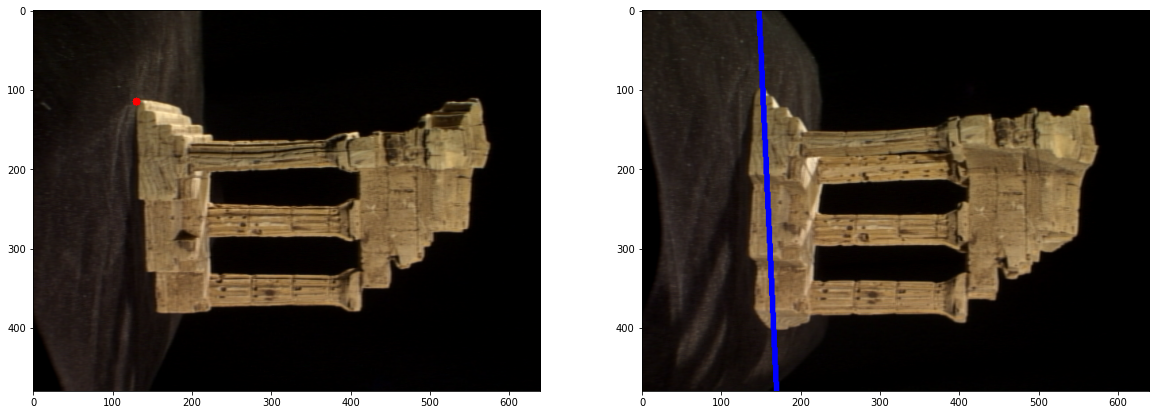

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [32]:
x = np.array([130, 115, 1])               
cv.circle(im1, (x[0], x[1]), 5, (0, 0, 255), -1)                

l2=F @ x.T
p1=np.array([0,(l2[0]*0+l2[2])/l2[1]]).astype(int)
p2=np.array([500, (l2[0]*500+l2[2])/l2[1]]).astype(int)
cv.line(im2,(p1[0],p1[1]),(p2[0],p2[1]),(255,0,0),5)

fix,ax=plt.subplots(1,2,figsize=(20,20))
imshowBGR(im1,ax[0])
imshowBGR(im2,ax[1])


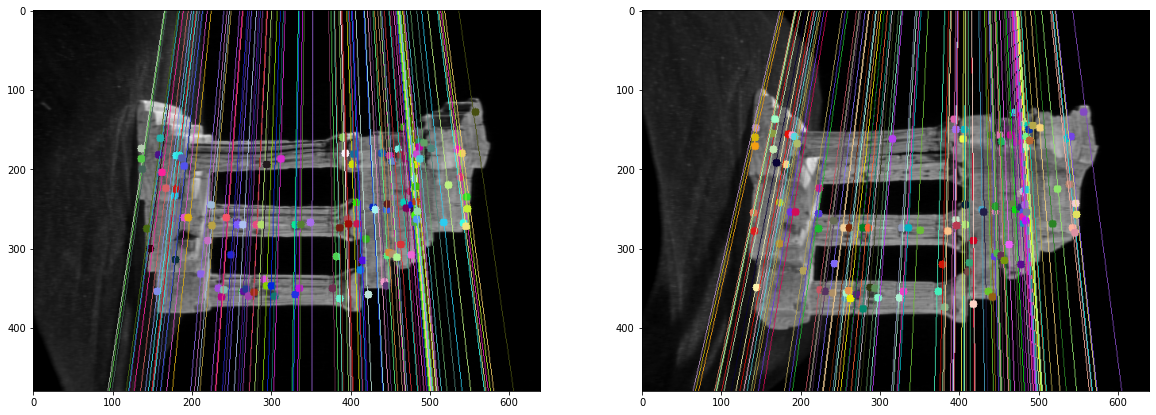

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [22]:
# q4

im1 = cv.imread(r'templeSparseRing/'+im1_fn,cv.IMREAD_GRAYSCALE)
im2 = cv.imread(r'templeSparseRing/'+im2_fn,cv.IMREAD_GRAYSCALE)
sift = cv.SIFT_create()

kp1, dp1 = sift.detectAndCompute(im1,None)
kp2, dp2 = sift.detectAndCompute(im2,None)

FLANN_INDEX_KDTREE = 1
indexParams = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
searchParams = dict(checks=50)
flann = cv.FlannBasedMatcher(indexParams,searchParams)
matches = flann.knnMatch(dp1,dp2,k=2)
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)

pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

def drawlines(im1,im2,lines,pts1,pts2):
    r,c = im1.shape
    im1 = cv.cvtColor(im1,cv.COLOR_GRAY2BGR)
    im2 = cv.cvtColor(im2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        im1 = cv.line(im1, (x0,y0), (x1,y1), color,1)
        im1 = cv.circle(im1,tuple(pt1),5,color,-1)
        im2 = cv.circle(im2,tuple(pt2),5,color,-1)
    return im1,im2

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
im5,im6 = drawlines(im1,im2,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
im3,im4 = drawlines(im2,im1,lines2,pts2,pts1)

fix,ax=plt.subplots(1,2,figsize=(20,20))
imshowBGR(im5,ax[0])
imshowBGR(im3,ax[1])

